In [1]:
!pip install -q -r requirements.txt 


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


In the previous chapter, we looked in depth at different aspects of the PyTorch neural network and
automatic differentiation modules, you became familiar with tensors and decorating functions, and
you learned how to work with torch.nn. In this chapter, you will now learn about convolutional neural
networks (CNNs) for image classification. We will start by discussing the basic building blocks of CNNs,
using a bottom-up approach. Then, we will take a deeper dive into the CNN architecture and explore
how to implement CNNs in PyTorch. In this chapter, we will cover the following topics:

*  Convolution operations in one and two dimensions
*  The building blocks of CNN architectures
*  Implementing deep CNNs in PyTorch
*  Data augmentation techniques for improving the generalization performance
*  Implementing a facial CNN classifier for recognizing if someone is smiling or not

In [2]:
!pip install -q numpy scipy torch 


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [3]:
def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate(
            [zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot))) + 1, s):
        res.append(np.sum(
            x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)


## Testing:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d Implementation:',
      conv1d(x, w, p=2, s=1))

print('Numpy Results:',
      np.convolve(x, w, mode='same')) 

NameError: name 'np' is not defined

In [ ]:
import numpy as np
import scipy.signal

def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
             p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0,int((X_padded.shape[0] - \
                   W_rot.shape[0])/s[0])+1, s[0]):

        res.append([])
        for j in range(0,
            int((X_padded.shape[1] - \
            W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))

    return(np.array(res))
X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]
print('Conv2d Implementation:\n',conv2d(X, W, p=(1, 1), s=(1, 1)))


print('SciPy Results:\n',scipy.signal.convolve2d(X, W, mode='same'))

Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
SciPy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


In [ ]:
import scipy.signal


def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
    p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - 
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - 
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

print('Conv2d Implementation:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))


print('SciPy Results:\n',
    scipy.signal.convolve2d(X, W, mode='same'))

Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
SciPy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


### Implementing a deep CNN using PyTorch

In [ ]:
import torchvision 
from torchvision import transforms 
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=True)

from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000)) 
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=False, 
                                           transform=transform, 
                                           download=False)

> Implementing a CNN using the torch.nn module
>> . Configuring CNN layers in PyTorch

In [ ]:
from torch.utils.data import DataLoader


batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

**constructing a CNN in pytorch**

In [ ]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))      

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

By providing the input shape as a tuple (4, 1, 28, 28) (4 images within the batch, 1 channel, and
image size 28×28), specified in this example, we calculated the output to have a shape (4, 64, 7, 7),
indicating feature maps with 64 channels and a spatial size of 7×7. The first dimension corresponds
to the batch dimension, for which we used 4 arbitrarily.

The next layer that we want to add is a fully connected layer for implementing a classifier on top of
our convolutional and pooling layers. The input to this layer must have rank 2, that is, shape [batch-
size × input_units]. Thus, we need to flatten the output of the previous layers to meet this requirement
for the fully connected layer:

As the output shape indicates, the input dimensions for the fully connected layer are correctly set up.
Next, we will add two fully connected layers with a dropout layer in between:

In [ ]:
model.add_module('flatten', nn.Flatten())
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

In [ ]:
model.add_module('fc1', nn.Linear(3136, 1024)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('dropout', nn.Dropout(p=0.5)) 

model.add_module('fc2', nn.Linear(1024, 10)) 
device = torch.device("cpu")
model.to(device)


Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)


Epoch 1 accuracy: 0.9492 val_accuracy: 0.9811
Epoch 2 accuracy: 0.9842 val_accuracy: 0.9867
Epoch 3 accuracy: 0.9893 val_accuracy: 0.9875
Epoch 4 accuracy: 0.9914 val_accuracy: 0.9890
Epoch 5 accuracy: 0.9928 val_accuracy: 0.9885
Epoch 6 accuracy: 0.9951 val_accuracy: 0.9911
Epoch 7 accuracy: 0.9952 val_accuracy: 0.9872
Epoch 8 accuracy: 0.9964 val_accuracy: 0.9879
Epoch 9 accuracy: 0.9970 val_accuracy: 0.9880
Epoch 10 accuracy: 0.9967 val_accuracy: 0.9908
Epoch 11 accuracy: 0.9972 val_accuracy: 0.9907
Epoch 12 accuracy: 0.9976 val_accuracy: 0.9900
Epoch 13 accuracy: 0.9976 val_accuracy: 0.9868
Epoch 14 accuracy: 0.9980 val_accuracy: 0.9889
Epoch 15 accuracy: 0.9976 val_accuracy: 0.9895
Epoch 16 accuracy: 0.9972 val_accuracy: 0.9918
Epoch 17 accuracy: 0.9985 val_accuracy: 0.9916
Epoch 18 accuracy: 0.9981 val_accuracy: 0.9910
Epoch 19 accuracy: 0.9981 val_accuracy: 0.9893
Epoch 20 accuracy: 0.9985 val_accuracy: 0.9906


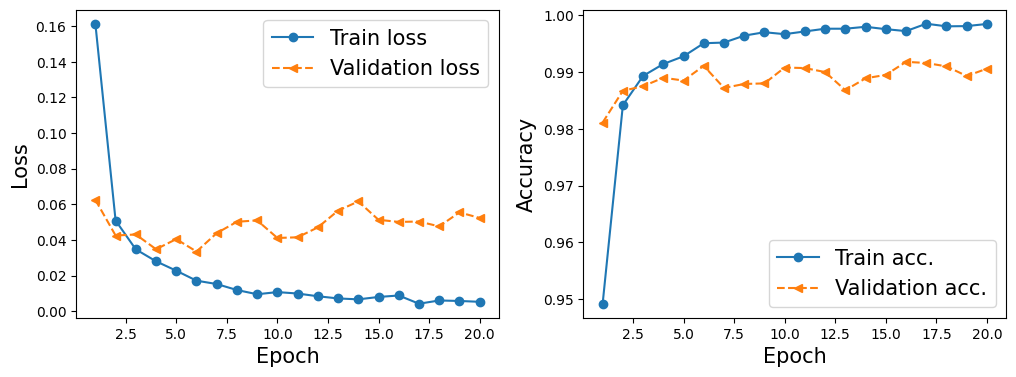

In [ ]:
import matplotlib.pyplot as plt


x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

In [ ]:
# torch.cuda.synchronize()
model_cpu = model.cpu()
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 

Test accuracy: 0.9926


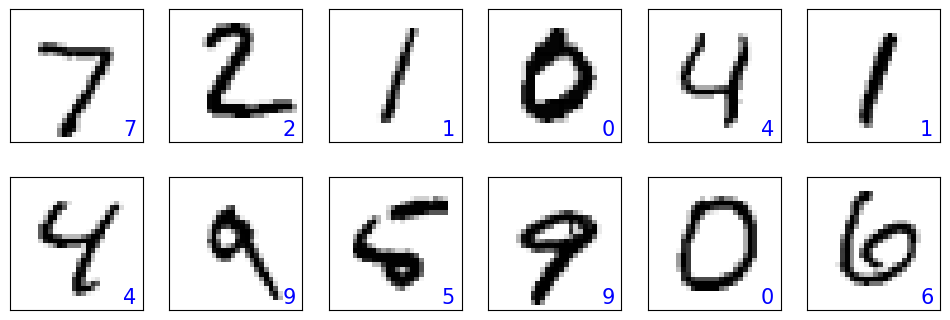

In [ ]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
    
#plt.savefig('figures/14_14.png')
plt.show()

In [ ]:
import os

if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/mnist-cnn.ph'
torch.save(model, path)
 

### Smile classification from face images using a CNN

In [2]:
import torch
import torch.nn as nn
import numpy as np

from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import torchvision 
import requests

image_path = './'
# celeba_train_dataset = torchvision.datasets.CelebA(image_path, split='train', target_type='attr', download=True)
# celeba_valid_dataset = torchvision.datasets.CelebA(image_path, split='valid', target_type='attr', download=False)
# celeba_test_dataset = torchvision.datasets.CelebA(image_path, split='test', target_type='attr', download=False)

# print('Train set:', len(celeba_train_dataset))
# print('Validation set:', len(celeba_valid_dataset))
# print('Test set:', len(celeba_test_dataset))

drive_link = f"https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing"
r = requests.get(drive_link)

with open('dataset.pt', 'wb') as f:
    f.write(r.content)

# Load dataset 
data = torch.load('dataset.pt')

print(data.shape)
print(data[:, 0])

UnpicklingError: invalid load key, '<'.

### Image transformation and data augmentation 

In [ ]:
from torchvision import transforms 

## take 5 examples

fig = plt.figure(figsize=(16, 8.5))

## Column 1: cropping to a bounding-box
ax = fig.add_subplot(2, 5, 1)
img, attr = celeba_train_dataset[0]
ax.set_title('Crop to a \nbounding-box', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 6)
img_cropped = transforms.functional.crop(img, 50, 20, 128, 128)
ax.imshow(img_cropped)

## Column 2: flipping (horizontally)
ax = fig.add_subplot(2, 5, 2)
img, attr = celeba_train_dataset[1]
ax.set_title('Flip (horizontal)', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 7)
img_flipped = transforms.functional.hflip(img)
ax.imshow(img_flipped)

## Column 3: adjust contrast
ax = fig.add_subplot(2, 5, 3)
img, attr = celeba_train_dataset[2]
ax.set_title('Adjust constrast', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 8)
img_adj_contrast = transforms.functional.adjust_contrast(img, contrast_factor=2)
ax.imshow(img_adj_contrast)

## Column 4: adjust brightness
ax = fig.add_subplot(2, 5, 4)
img, attr = celeba_train_dataset[3]
ax.set_title('Adjust brightness', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 9)
img_adj_brightness = transforms.functional.adjust_brightness(img, brightness_factor=1.3)
ax.imshow(img_adj_brightness)

## Column 5: cropping from image center 
ax = fig.add_subplot(2, 5, 5)
img, attr = celeba_train_dataset[4]
ax.set_title('Center crop\nand resize', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 10)
img_center_crop = transforms.functional.center_crop(img, [0.7*218, 0.7*178])
img_resized = transforms.functional.resize(img_center_crop, size=(218, 178))
ax.imshow(img_resized)
 
# plt.savefig('figures/14_14.png', dpi=300)
plt.show()

In [ ]:
torch.manual_seed(1)

fig = plt.figure(figsize=(14, 12))

for i, (img, attr) in enumerate(celeba_train_dataset):
    ax = fig.add_subplot(3, 4, i*4+1)
    ax.imshow(img)
    if i == 0:
        ax.set_title('Orig.', size=15)
        
    ax = fig.add_subplot(3, 4, i*4+2)
    img_transform = transforms.Compose([transforms.RandomCrop([178, 178])])
    img_cropped = img_transform(img)
    ax.imshow(img_cropped)
    if i == 0:
        ax.set_title('Step 1: Random crop', size=15)

    ax = fig.add_subplot(3, 4, i*4+3)
    img_transform = transforms.Compose([transforms.RandomHorizontalFlip()])
    img_flip = img_transform(img_cropped)
    ax.imshow(img_flip)
    if i == 0:
        ax.set_title('Step 2: Random flip', size=15)

    ax = fig.add_subplot(3, 4, i*4+4)
    img_resized = transforms.functional.resize(img_flip, size=(128, 128))
    ax.imshow(img_resized)
    if i == 0:
        ax.set_title('Step 3: Resize', size=15)
    
    if i == 2:
        break
        
# plt.savefi
plt.show()


In [ ]:
get_smile = lambda attr: attr[31]
 
transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

In [10]:
from torch.utils.data import DataLoader

celeba_train_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='train', 
                                                   target_type='attr', 
                                                   download=False, 
                                                   transform=transform_train,
                                                   target_transform=get_smile)

torch.manual_seed(1)
data_loader = DataLoader(celeba_train_dataset, batch_size=2)

fig = plt.figure(figsize=(15, 6))

num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(data_loader))
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))
      
    
#plt.savefig('figures/14_16.png', dpi=300)
plt.show()

NameError: name 'transform_train' is not defined

In [ ]:
eleba_valid_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='valid', 
                                                   target_type='attr', 
                                                   download=False, 
                                                   transform=transform,
                                                   target_transform=get_smile)

celeba_test_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='test', 
                                                   target_type='attr', 
                                                   download=False, 
                                                   transform=transform,
                                                   target_transform=get_smile)

from torch.utils.data import Subset
celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(16000)) 
celeba_valid_dataset = Subset(celeba_valid_dataset, torch.arange(1000)) 
 
print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))

In [11]:
batch_size = 32

torch.manual_seed(1)
train_dl = DataLoader(celeba_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset, batch_size, shuffle=False)
test_dl = DataLoader(celeba_test_dataset, batch_size, shuffle=False)

NameError: name 'celeba_train_dataset' is not defined

In [ ]:
import torch.nn as nn

model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))  
model.add_module('dropout1', nn.Dropout(p=0.5)) 

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))   
model.add_module('dropout2', nn.Dropout(p=0.5)) 

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())        
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))   

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())  

In [ ]:
x = torch.ones((4, 3, 64, 64))
model(x).shape

In [ ]:
model.add_module('pool4', nn.AvgPool2d(kernel_size=8)) 
model.add_module('flatten', nn.Flatten()) 

x = torch.ones((4, 3, 64, 64))
model(x).shape

In [ ]:
model.add_module('fc', nn.Linear(256, 1)) 
model.add_module('sigmoid', nn.Sigmoid()) 

In [ ]:
x = torch.ones((4, 3, 64, 64))
model(x).shape

In [ ]:
model